# EEG Net Accuracy

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

import tensorflow as tf

from utils import get_data

In [4]:
CLASS_DICT = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM"
}

SPLIT = 'split3'

In [3]:
model = tf.keras.saving.load_model(f'models/eegNet/{SPLIT}/trained_model.h5')

train_ds, val_ds, test_ds, class_weights, max_len = get_data(batch_size=64)

2024-04-21 12:58:17.562730: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-21 12:58:17.562753: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-21 12:58:17.562758: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-21 12:58:17.562792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-21 12:58:17.562807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Load training set:
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4001E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4002E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4011E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4012E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4021E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4022E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4041E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4042E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4051E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4052E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4061E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4062E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepared/fpz_cz/SC4081E0.npz ...
Loading ../SESM/datasets/eeg/sleep_edf/prepar

In [4]:
# Extract data and labels from the dataset
test_data = []
test_labels = []
for x, y in test_ds:
    test_data.append(x)
    test_labels.append(y)

# Concatenate the dataset batches into NumPy arrays
test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

os.makedirs('test_outputs', exist_ok=True)
os.makedirs(f'test_outputs/{SPLIT}', exist_ok=True)

with open(f'test_outputs/{SPLIT}/y_true_test.pkl','wb') as f:
    pickle.dump(test_labels, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'test_outputs/{SPLIT}/y_pred_test.pkl','wb') as f:
    pickle.dump(predicted_labels, f, protocol=pickle.HIGHEST_PROTOCOL)


  7/199 [>.............................] - ETA: 3s

2024-04-21 12:58:20.114737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 19ms/step


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')

# Create a confusion matrix
confusion = confusion_matrix(test_labels, predicted_labels)

class_names = CLASS_DICT.values()

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted Labels')
plt.gca().set_xticklabels(class_names)
plt.ylabel('True Labels')
plt.gca().set_yticklabels(class_names)
plt.show()

# Generate a classification report
report = classification_report(test_labels, predicted_labels, target_names=class_names)
print(report)

# Calculate class-wise accuracy
class_accuracy = confusion.diagonal()/confusion.sum(axis=1)

print("\n")
# Print class-wise accuracy
for i, class_name in enumerate(class_names):
    print(f'Accuracy for {class_name}: {class_accuracy[i]*100:.2f}%')

plt.show()

# Calculate main results

In [8]:
confusion.diagonal()/confusion.sum(axis=1)

array([0.622, 0.58 ])

In [20]:
class_names = CLASS_DICT.values()

# Load the experiments
splits = ['split0','split1','split2','split3']
split_results = []
classwise_accuracies = []

for split in splits:
    print(split)

    with open(f'test_outputs/{split}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/{split}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    row = {
        "experiment": split,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }
    split_results.append(row)

    # Create a confusion matrix
    confusion = confusion_matrix(y_true, y_pred)
    class_accuracy = confusion.diagonal()/confusion.sum(axis=1)

    classwise_row = { class_name: class_accuracy[i] for i, class_name in enumerate(class_names) }
    classwise_row["experiment"] = split
    classwise_accuracies.append(classwise_row)

split0
split1
split2
split3


In [21]:
results_df = pd.DataFrame(split_results)
classwise_results = pd.DataFrame(classwise_accuracies)

display(results_df)
display(classwise_results)

,experiment,accuracy,precision,recall
0,split0,0.724176,0.702430,0.709446
1,split1,0.710102,0.658614,0.747781
2,split2,0.712681,0.695824,0.724347
3,split3,0.681062,0.617089,0.693151


,W,N1,N2,N3,REM,experiment
0,0.681600,0.524194,0.783307,0.982166,0.575966,split0
1,0.802535,0.613232,0.612448,0.998569,0.712121,split1
2,0.527197,0.571709,0.737854,0.989293,0.795680,split2
3,0.726490,0.430693,0.540386,0.948255,0.819930,split3


In [22]:
# Calculate mean and standard deviation
agg_mean = results_df.loc[[0,1,2],["accuracy","precision", "recall"]].mean()
agg_std = results_df.loc[[0,1,2],["accuracy","precision", "recall"]].std()

# Create a new dataframe for aggregation
agg_df = pd.DataFrame({'mean': agg_mean, 'std': agg_std})
display(agg_df)

,mean,std
accuracy,0.715653,0.007493
precision,0.685623,0.023622
recall,0.727191,0.019325


In [23]:
# Calculate mean and standard deviation
classwise_agg_mean = classwise_results.loc[[0,1,2],list(class_names)].mean()
classwise_agg_std = classwise_results.loc[[0,1,2],list(class_names)].std()

# Create a new dataframe for classwise_aggregation
classwise_agg_df = pd.DataFrame({'mean': classwise_agg_mean, 'std': classwise_agg_std})
display(classwise_agg_df)

,mean,std
W,0.670444,0.138008
N1,0.569711,0.044553
N2,0.711203,0.088492
N3,0.990009,0.008225
REM,0.694589,0.110901


In [24]:
y_trues = []
y_preds = []

for split in ["split0","split1","split2"]:

    with open(f'test_outputs/{split}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/{split}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)
    
    y_trues.append(y_true)
    y_preds.append(y_pred)

y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)

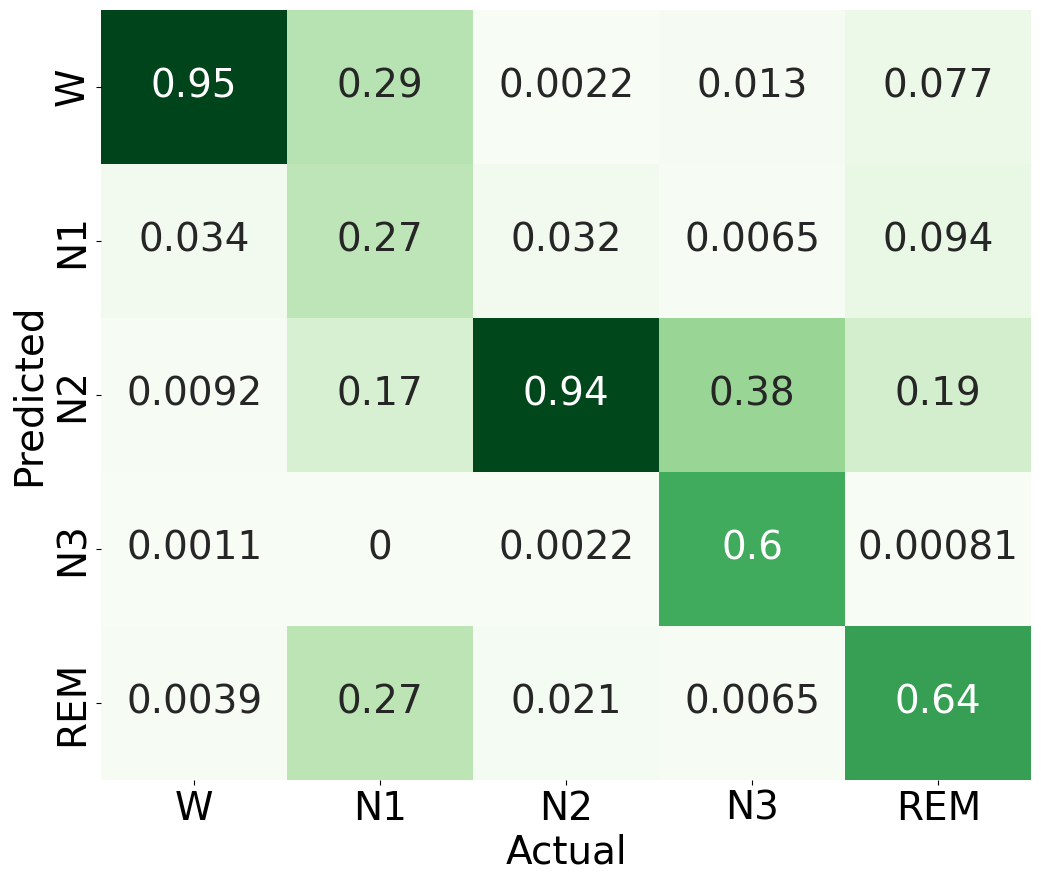

In [25]:
C = confusion_matrix(y_true, y_pred)
C = C / C.astype(float).sum(axis=0)

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    C,
    annot=True,
    annot_kws={"fontsize":28},
    cmap='Greens',
    cbar=False
)
ax.set_xticklabels(CLASS_DICT.values(), fontsize=28)
ax.set_yticklabels(CLASS_DICT.values(), fontsize=28)
ax.set_xlabel("Actual", fontsize=28)
ax.set_ylabel("Predicted", fontsize=28)
plt.show()